## Example of Primer oscillator (DeepXDE).
Use physics-informed neural network (PINN) to solve Primer oscillator.<br>
The specific equation is as follows:

\begin{equation}
 \frac {du} {dt} + 0.1 u - sin(\pi*t/2) = 0,
 \end{equation}
 with initial condition u(0) = 1.

Used to make Figures X to X in paper.


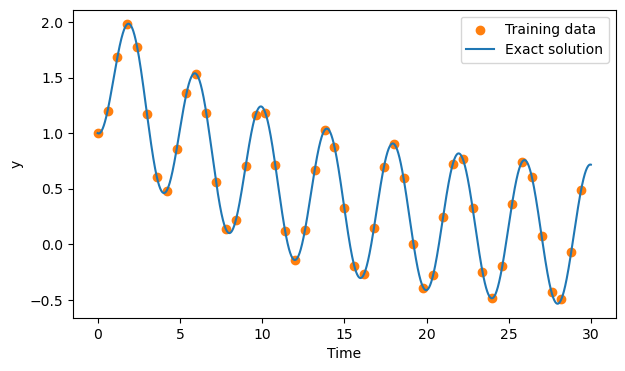

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def oscillator_model(t):
    def func(y, t):
        return - 0.1 * y + np.sin(np.pi * t / 2.0)
    y0 = 1.0
    return odeint(func, y0, t)

t = np.arange(0, 30, 0.01)[:, None]
y = oscillator_model(np.ravel(t))

t_data=t[0:3000:60] # 119
y_data=y[0:3000:60] 

plt.figure(figsize=(7, 4))
plt.xlabel("Time")
plt.ylabel("y")
plt.scatter(t_data, y_data, color="tab:orange", label="Training data")
plt.plot(t, y, label="Exact solution")
plt.legend()
plt.show()

In [14]:
import deepxde as dde
import time
from deepxde.backend import tf

geom = dde.geometry.TimeDomain(0.0, 30.0)

def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    return dy_dt + 0.1 * y - tf.sin(np.pi * t / 2)

def boundary(t, on_boundary):
    return on_boundary

t_y_data = dde.PointSetBC(t_data, y_data)

ic = dde.icbc.IC(geom, lambda x: 1, boundary, component=0)
bc = dde.DirichletBC(geom, lambda x: 1, boundary, component=0)

data = dde.data.PDE(
    geom, ode, [ic, bc, t_y_data], train_distribution = "uniform", num_domain = 48, num_boundary = 1, num_test = 200
)

net = dde.maps.FNN([1] + [32] * 3 + [1], "tanh", "Glorot normal")


model = dde.Model(data, net)
model.compile("adam", lr=3e-3)

# start_time = time.time()

model.train(epochs=24000)

# losshistory, train_state = model.train(epochs=24000)
# end_time = time.time()
# total_time = end_time - start_time
# print(f"Total training time: {total_time:.2f} seconds")
# dde.saveplot(losshistory, train_state, isplot=True)

y_pred = model.predict(t)


Compiling model...
Building feed-forward neural network...
'build' took 0.052555 s

'compile' took 0.469845 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.01e-01, 1.00e+00, 1.00e+00, 8.63e-01]    [4.98e-01, 1.00e+00, 1.00e+00, 8.63e-01]    []  
1000      [3.39e-01, 3.26e-07, 3.26e-07, 1.37e-01]    [3.40e-01, 3.26e-07, 3.26e-07, 1.37e-01]    []  
2000      [2.46e-01, 2.83e-10, 2.83e-10, 1.01e-01]    [2.47e-01, 2.83e-10, 2.83e-10, 1.01e-01]    []  
3000      [1.66e-01, 5.36e-06, 5.36e-06, 6.52e-02]    [1.67e-01, 5.36e-06, 5.36e-06, 6.52e-02]    []  
4000      [1.00e-01, 3.72e-06, 3.72e-06, 4.12e-02]    [1.01e-01, 3.72e-06, 3.72e-06, 4.12e-02]    []  
5000      [5.28e-03, 2.24e-06, 2.24e-06, 1.28e-03]    [9.18e-03, 2.24e-06, 2.24e-06, 1.28e-03]    []  
6000      [1.92e-03, 2.13e-07, 2.13e-07, 2.25e-04]    [6.85e-03, 2.13e-07, 2.13e-07, 2.25e-04]    []  
7000      [1.05e-03, 6.28e-08, 6.28e-08

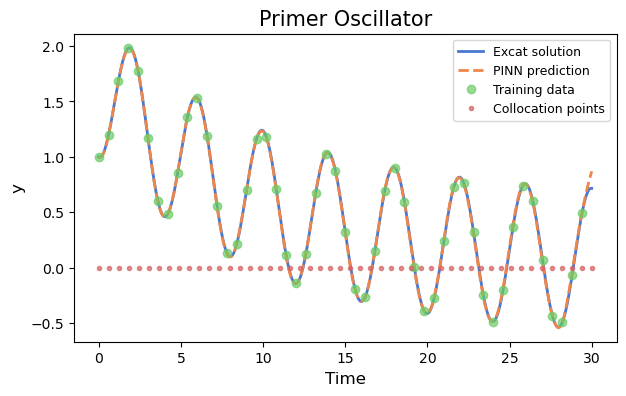

In [13]:
import seaborn as sns

palette = sns.color_palette("muted")

num_domain = np.linspace(0, 30, 50)

plt.figure(figsize=(7, 4))
plt.plot(t, y, '-', color=palette[0], linewidth=2, label='Excat solution')
plt.plot(t, y_pred, '--', color=palette[1], linewidth=2, label='PINN prediction')
plt.plot(t_data, y_data, 'o', color=palette[2], linewidth=2, alpha=0.7, label='Training data')
plt.plot(num_domain, np.zeros_like(num_domain), '.', color=palette[3], linewidth=2, alpha=0.7, label='Collocation points')
plt.title('Primer Oscillator', fontsize=15, fontweight='medium')
plt.xlabel('Time', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(frameon=True, loc='upper right', fontsize=9)
plt.show()